In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from util import *
%matplotlib inline

from sksurv.datasets import load_breast_cancer
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sksurv.preprocessing import OneHotEncoder

from sklearn.model_selection import GridSearchCV, KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [2]:
#產測資
import tensorflow as tf
y = tf.random.normal([1000, 2], mean=10, stddev=2, seed = 1)
X = tf.random.normal([1000, 1000], mean=10, stddev=4, seed = 1)
y = np.array(y)
X = np.array(X)
X = pd.DataFrame(X,columns=np.arange(1000).astype(str))

In [3]:
label = (y[:,0]>10)
output = []
for i in range(1000):
    output.append((label[i],y[i,1]))
y = np.array(output,dtype='bool,float')

In [4]:
# cox-lasso
cox_lasso = CoxnetSurvivalAnalysis(l1_ratio=1.0, alpha_min_ratio=0.01)
cox_lasso.fit(X, y)

CoxnetSurvivalAnalysis(alpha_min_ratio=0.01, l1_ratio=1.0)

In [5]:
# draw coefficients plot
def plot_coefficients(coefs, n_highlight):
    _, ax = plt.subplots(figsize=(9, 6))
    n_features = coefs.shape[0]
    alphas = coefs.columns
    coefs_plot = coefs.loc[coefs.loc[:, alphas.min()].map(abs).sort_values().tail(100).index]
    for row in coefs_plot.itertuples():
        ax.semilogx(alphas, row[1:], ".-", label=row.Index)

    alpha_min = alphas.min()
    top_coefs = coefs.loc[:, alpha_min].map(abs).sort_values().tail(n_highlight)
    for name in top_coefs.index:
        coef = coefs.loc[name, alpha_min]
        plt.text(
            alpha_min, coef, name + "   ",
            horizontalalignment="right",
            verticalalignment="center"
        )

    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.grid(True)
    ax.set_xlabel("alpha")
    ax.set_ylabel("coefficient")

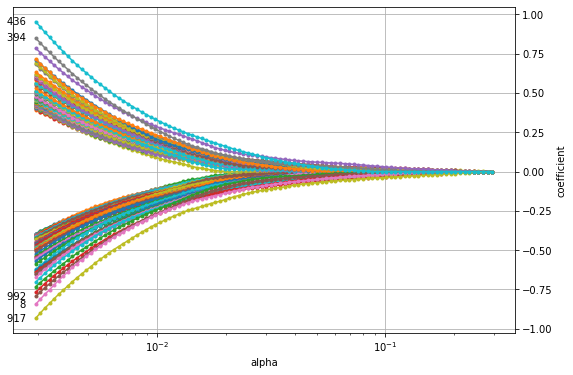

In [6]:
coefficients_lasso = pd.DataFrame(
    cox_lasso.coef_,
    index=X.columns,
    columns=np.round(cox_lasso.alphas_, 5)
)

plot_coefficients(coefficients_lasso, n_highlight=5)

In [7]:
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

coxnet_pipe = make_pipeline(
    StandardScaler(),
    CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.01, max_iter=100)
)
warnings.simplefilter("ignore", ConvergenceWarning)
coxnet_pipe.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('coxnetsurvivalanalysis',
                 CoxnetSurvivalAnalysis(alpha_min_ratio=0.01, l1_ratio=0.9,
                                        max_iter=100))])

In [14]:
estimated_alphas = coxnet_pipe.named_steps["coxnetsurvivalanalysis"].alphas_[:50]
cv = KFold(n_splits=5, shuffle=True, random_state=0)
gcv = GridSearchCV(
    make_pipeline(StandardScaler(), CoxnetSurvivalAnalysis(l1_ratio=0.9)),
    param_grid={"coxnetsurvivalanalysis__alphas": [[v] for v in estimated_alphas]},
    cv=cv,
    error_score=0.5,
    n_jobs=4).fit(X, y)

cv_results = pd.DataFrame(gcv.cv_results_)

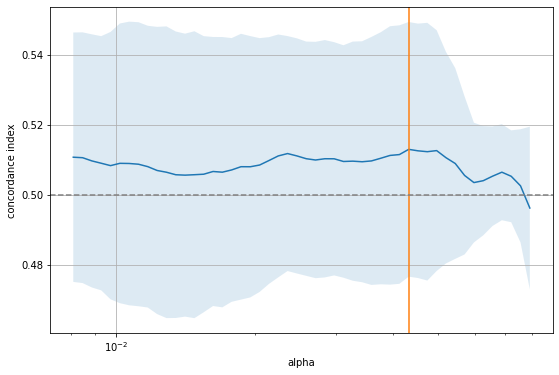

In [15]:
alphas = cv_results.param_coxnetsurvivalanalysis__alphas.map(lambda x: x[0])
mean = cv_results.mean_test_score
std = cv_results.std_test_score

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(alphas, mean)
ax.fill_between(alphas, mean - std, mean + std, alpha=.15)
ax.set_xscale("log")
ax.set_ylabel("concordance index")
ax.set_xlabel("alpha")
ax.axvline(gcv.best_params_["coxnetsurvivalanalysis__alphas"][0], c="C1")
ax.axhline(0.5, color="grey", linestyle="--")
ax.grid(True)

Number of non-zero coefficients: 78


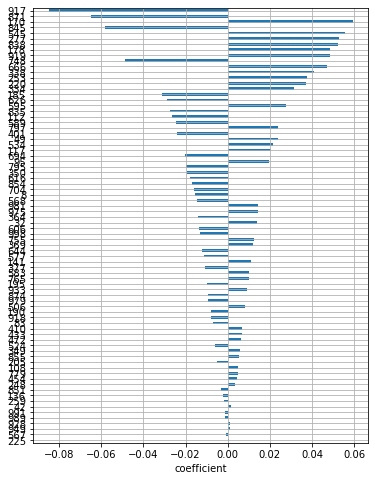

In [17]:
best_model = gcv.best_estimator_.named_steps["coxnetsurvivalanalysis"]
best_coefs = pd.DataFrame(
    best_model.coef_,
    index=X.columns,
    columns=["coefficient"]
)

non_zero = np.sum(best_coefs.iloc[:, 0] != 0)
print("Number of non-zero coefficients: {}".format(non_zero))

non_zero_coefs = best_coefs.query("coefficient != 0")
coef_order = non_zero_coefs.abs().sort_values("coefficient").index

_, ax = plt.subplots(figsize=(6, 8))
non_zero_coefs.loc[coef_order].plot.barh(ax=ax, legend=False)
ax.set_xlabel("coefficient")
ax.grid(True)

In [18]:
#randoom survival forest
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder

from sksurv.datasets import load_gbsg2
from sksurv.preprocessing import OneHotEncoder
from sksurv.ensemble import RandomSurvivalForest

In [36]:
X, y = load_gbsg2()

grade_str = X.loc[:, "tgrade"].astype(object).values[:, np.newaxis]
grade_num = OrdinalEncoder(categories=[["I", "II", "III"]]).fit_transform(grade_str)

X_no_grade = X.drop("tgrade", axis=1)
Xt = OneHotEncoder().fit_transform(X_no_grade)
Xt = np.column_stack((Xt.values, grade_num))

feature_names = X_no_grade.columns.tolist() + ["tgrade"]

In [37]:
random_state = 20

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=random_state)

In [38]:
rsf = RandomSurvivalForest(n_estimators=1000,
                           min_samples_split=10,
                           min_samples_leaf=15,
                           max_features="sqrt",
                           n_jobs=-1,
                           random_state=random_state)
rsf.fit(X_train, y_train)

RandomSurvivalForest(max_features='sqrt', min_samples_leaf=15,
                     min_samples_split=10, n_estimators=1000, n_jobs=-1,
                     random_state=20)

In [39]:
rsf.score(X_test, y_test)

0.5965346534653465

In [41]:
# from sklearn.inspection import permutation_importance

# perm = permutation_importance(rsf, X_test, y_test, n_repeats=15, random_state=random_state)
# for i in perm.importances_mean.argsort()[::-1]:
#      if perm.importances_mean[i] - 2 * perm.importances_std[i] > 0:
#         print(f"{feature_names[i]:<8}  "
#               f"{perm.importances_mean[i]:.3f}"
#               f" +/- {perm.importances_std[i]:.3f}")

In [57]:
import eli5
from eli5.sklearn import PermutationImportance

feature_names = X_test.columns.tolist()
perm = PermutationImportance(rsf, n_iter=15, random_state=random_state)
perm.fit(X_test, y_test)
eli5.explain_weights(perm, feature_names=feature_names, top=100)

Weight,Feature
0.0254 ± 0.0499,X202240_at
0.0233 ± 0.0386,X204014_at
0.0183 ± 0.0181,X203306_s_at
0.0178 ± 0.0408,X219724_s_at
0.0058 ± 0.0275,X218883_s_at
0.0054 ± 0.0032,X203391_at
0.0036 ± 0.0036,X207118_s_at
0.0030 ± 0.0106,X208180_s_at
0.0030 ± 0.0079,X201663_s_at
0.0018 ± 0.0049,X204888_s_at
